In [13]:
import keras
from keras.layers import Flatten ,Dense
from keras.models import Model 
from keras.datasets import mnist
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
import itertools
from sklearn import svm, datasets
from imgaug import augmenters as iaa
from sklearn.metrics import confusion_matrix

from keras.applications import InceptionV3


from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir(r'/content/drive/My Drive/Chest_xray')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class MyData():
    def __init__(self,path):
        self.path = path
        self.names = list()
        
       
    def load_data(self): 
        X=[]
        Y=[]
        for ii,row in enumerate(os.walk(self.path)):
            if ii == 0:
                self.names= row[1]
            else:
                path_1,dic_1,data_1 = row 
                for img in data_1:
                    X.append(os.path.join(path_1,img))
                    Y.append(self.names[ii-1])

        for index in range(len(Y)):
            for lable in range(len(self.names)):
                if self.names[lable] == Y[index]:
                     Y[index] = MyData.one_hote(lable,len(self.names))

        X = np.array(X)
        Y = np.array(Y)

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


        return (x_train, y_train), (x_test, y_test)
    
    @staticmethod
    def one_hote(y,n):
        I = np.zeros(n)
        I[y]= 1
        return I

In [0]:
def data_generator(X,Y,batch_size = 4,size = (160,160), random = True, randon_Aug = False):
    start_index = 0
    while True:
        if random == False:
            end = min(start+batch_size ,X.shape[0])
            img_paths = X[start:end]
            img_labels = Y[start:end]
            start = end%X.shape[0]
        else:  # choose batch_size random images / labels from the data
            idx = np.random.randint(0, X.shape[0], batch_size)
            img_paths = X[idx]
            img_labels = Y[idx]
        imgs = [cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB) for img_path in img_paths]
        imgs = [cv2.resize(img,size) for img in imgs]
        imgs = np.array(imgs)
        if randon_Aug == True:
            imgs = randonAug(imgs)
        yield imgs,img_labels

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
def randonAug(imgs):
  new_array=[]
  for image in imgs:  
      aug = iaa.OneOf([iaa.GaussianBlur(sigma=1),iaa.Add(50, per_channel=True),iaa.Sharpen(alpha=1),iaa.Fliplr(0.5)])
      image = aug.augment_image(image)
      new_array.append(image)
  new_array = np.array(new_array)
  return new_array

In [18]:

data_set = MyData(r'/content/drive/My Drive/Chest_xray')
(x_train, y_train), (x_test, y_test) = data_set.load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [0]:
model = InceptionV3(weights = None ,include_top = False , input_shape = (160,160,3))

In [0]:
x = model.output
x = Flatten()(x)
x =Dense(1024, activation ='relu',  name='fc1')(x)
x =Dense(512, activation ='relu',   name='fc2')(x)
out = Dense(2,activation="sigmoid",name= 'fc_out')(x)

In [0]:
model = Model(model.input , out)

In [0]:
from keras.optimizers import Adam
model.compile(optimizer = Adam( lr=0.00001),
                 loss ='categorical_crossentropy' ,
                  metrics = ['acc'])

In [0]:
gen_train  = data_generator(x_train,y_train)
gen_val  = data_generator(x_test,y_test)

In [24]:
his1 = model.fit_generator(gen_train, steps_per_epoch = x_train.shape[0]//48,validation_steps = x_test.shape[0]//4,validation_data = gen_val, epochs=10)

Epoch 1/10
97/97 [==============================] - 337s 3s/step - loss: 0.4444 - acc: 0.7603 - val_loss: 0.4095 - val_acc: 0.7824
Epoch 2/10
97/97 [==============================] - 190s 2s/step - loss: 0.4291 - acc: 0.7912 - val_loss: 0.3706 - val_acc: 0.8379
Epoch 3/10
97/97 [==============================] - 128s 1s/step - loss: 0.3815 - acc: 0.7964 - val_loss: 0.3978 - val_acc: 0.7227
Epoch 4/10
97/97 [==============================] - 114s 1s/step - loss: 0.4196 - acc: 0.7912 - val_loss: 0.3744 - val_acc: 0.8234
Epoch 5/10
97/97 [==============================] - 110s 1s/step - loss: 0.4200 - acc: 0.8170 - val_loss: 0.3586 - val_acc: 0.7901
Epoch 6/10
97/97 [==============================] - 99s 1s/step - loss: 0.2989 - acc: 0.8428 - val_loss: 0.4345 - val_acc: 0.7534
Epoch 7/10
97/97 [==============================] - 105s 1s/step - loss: 0.3772 - acc: 0.8325 - val_loss: 0.2990 - val_acc: 0.8763
Epoch 8/10
97/97 [==============================] - 83s 852ms/step - loss: 0.4067 - 

model accuracy


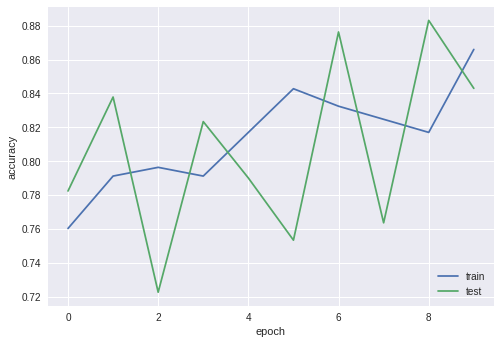

model loss


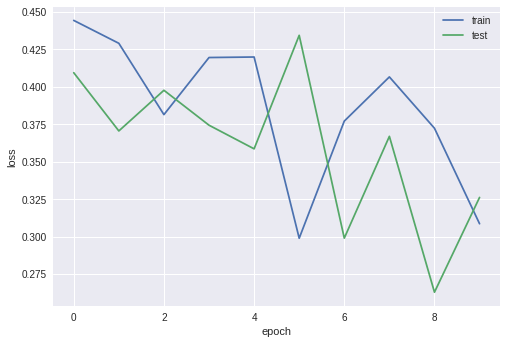

In [25]:

# summarize history for accuracy
plt.plot(his1.history['acc'])
plt.plot(his1.history['val_acc'])
print('model accuracy')
plt.title = 'model accuracy'
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for loss
print('model loss')
plt.plot(his1.history['loss'])
plt.plot(his1.history['val_loss'])
plt.title = 'model loss'
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
test_imgs = [cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB) for img_path in x_test]
test_imgs = [cv2.resize(img,(160,160)) for img in test_imgs]
test_imgs = np.array(test_imgs)

Confusion matrix, without normalization
[[160 181]
 [ 18 813]]


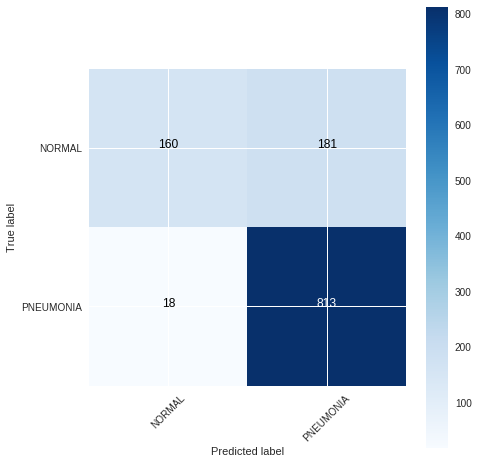

In [27]:
y_pred=model.predict(test_imgs)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=[7,7])
names = data_set.names
plot_confusion_matrix(cnf_matrix, classes=names, normalize=False)
plt.show()

In [0]:
v_model = VGG16(weights = None ,include_top = False , input_shape = (160,160,3))

In [0]:
x = v_model.output
x = Flatten()(x)
x =Dense(1024, activation ='relu',  name='fc1')(x)
x =Dense(512, activation ='relu',   name='fc2')(x)
out = Dense(2,activation="sigmoid",name= 'fc_out')(x)

In [0]:
vgg_model = Model(v_model.input , out)

In [0]:
vgg_model.compile(optimizer = Adam( lr=0.00001),
                 loss ='categorical_crossentropy' ,
                  metrics = ['acc'])

In [0]:
gen_train  = data_generator(x_train,y_train,random=True,randon_Aug = True)
gen_val  = data_generator(x_test,y_test,random=True,randon_Aug = False)

In [33]:
his2 = vgg_model.fit_generator(gen_train, steps_per_epoch = x_train.shape[0]//48,validation_steps = x_test.shape[0]//4,validation_data = gen_val, epochs=10)

Epoch 1/10
97/97 [==============================] - 86s 889ms/step - loss: 0.5810 - acc: 0.7088 - val_loss: 0.4839 - val_acc: 0.7312
Epoch 2/10
97/97 [==============================] - 69s 708ms/step - loss: 0.5224 - acc: 0.7552 - val_loss: 0.5380 - val_acc: 0.8251
Epoch 3/10
97/97 [==============================] - 71s 736ms/step - loss: 0.4247 - acc: 0.8067 - val_loss: 0.3665 - val_acc: 0.8217
Epoch 4/10
97/97 [==============================] - 73s 748ms/step - loss: 0.3870 - acc: 0.8325 - val_loss: 0.2534 - val_acc: 0.8993
Epoch 5/10
97/97 [==============================] - 63s 648ms/step - loss: 0.2969 - acc: 0.8969 - val_loss: 0.1910 - val_acc: 0.9249
Epoch 6/10
97/97 [==============================] - 62s 642ms/step - loss: 0.2945 - acc: 0.8840 - val_loss: 0.2352 - val_acc: 0.9198
Epoch 7/10
97/97 [==============================] - 70s 724ms/step - loss: 0.2346 - acc: 0.8995 - val_loss: 0.2228 - val_acc: 0.9104
Epoch 8/10
97/97 [==============================] - 58s 602ms/step - 

model accuracy


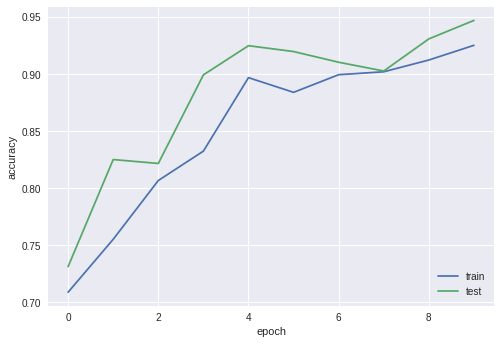

model loss


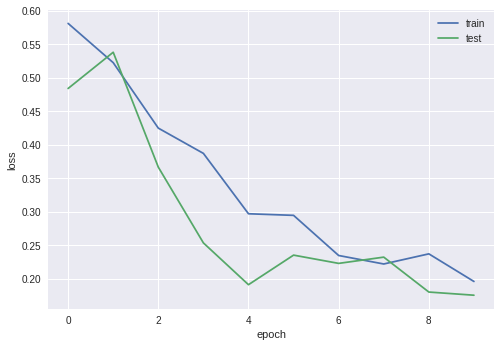

In [34]:
# summarize history for accuracy
plt.plot(his2.history['acc'])
plt.plot(his2.history['val_acc'])
print('model accuracy')
plt.title = 'model accuracy'
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for loss
print('model loss')
plt.plot(his2.history['loss'])
plt.plot(his2.history['val_loss'])
plt.title = 'model loss'
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

None W confusion Matrix
Confusion matrix, without normalization
[[309  32]
 [ 40 791]]


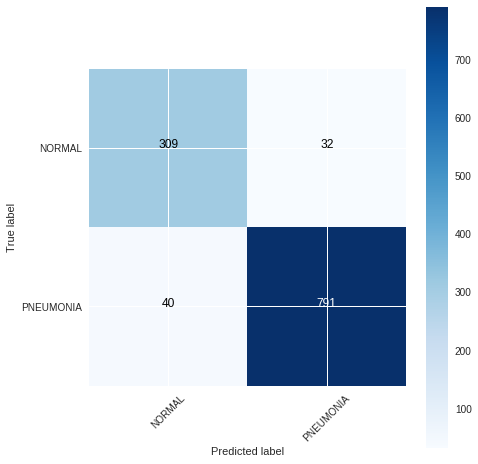

In [35]:
y_pred=vgg_model.predict(test_imgs)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
print("None W confusion Matrix")
# Plot normalized confusion matrix
plt.figure(figsize=[7,7])
names = data_set.names
plot_confusion_matrix(cnf_matrix, classes=names, normalize=False)
plt.show()

In [0]:
from keras import layers
def ensemble_models(models, model_input):
    temp_models=[model(model_input) for model in models] 
    avg_models=layers.average(temp_models) 
    return Model(inputs=model_input, outputs=avg_models, name='ensemble')  

In [0]:
from keras.layers import Input
listOfModels = [model , vgg_model]
model_input = Input(shape=listOfModels[1].input_shape[1:]) 
model_ens = ensemble_models(listOfModels, model_input)

In [0]:
from keras.optimizers import SGD
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_ens.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

None W confusion Matrix
Confusion matrix, without normalization
[[232 109]
 [ 13 818]]


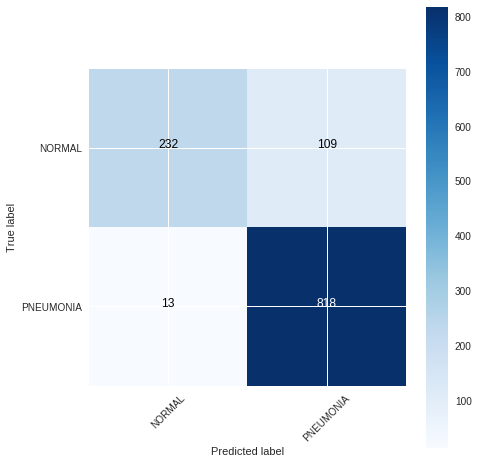

In [58]:
y_pred=model_ens.predict(test_imgs)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
print("None W confusion Matrix")
# Plot normalized confusion matrix
plt.figure(figsize=[7,7])
names = data_set.names
plot_confusion_matrix(cnf_matrix, classes=names, normalize=False)
plt.show()



So my final project was chosen to deal with the classification of lung and whether there is pneumonia or not.
As you can see in the notebook I tried to work with two types of neural networks first is InceptionV3 and the second is VGG16.
When I started working with InceptionV3, I still did not use the augmentation, but I lowered the optimizer's lr as much as possible until I got good results and reached 84%
After this, to improve the results, I added augmentation learning, but in the given network the results did not improve in a brilliant way. Therefore, I decided to switch to the second network, VGG16, on which I activated augments from the imgaug library.
The augmentation was carefully selected after many experiments until the results of 95% success.
It is very important to notice by the matrices that most of the mistakes of the machine are when a healthy lung machine claims to have inflammation which is preferable to the opposite case.
In order to improve the results and make the machine work more efficiently I decided to make an ensemble between the models and thus get the best model and so it happened.
This can be seen by the last matrix, which was significantly altered in the machine's errors when the lung with inflammation.

It is important to note that during the work on the project, I tried to combine work with bbox, which could limit the area of the disease, but I failed in my task because of time and pressure.

In conclusion, I am very happy to have chosen the course I have studied and practiced in a way that I have not yet encountered the title I would like to thank the tutor Or Katz and the lecturer Eyal Katz for an interesting and profound work on the material.
But one thing I would like to improve on is the second part of the course on Neural Networks. I think that the following students in the course will be able to study a course on Neural Networks, which can greatly help and improve the understanding of the subject. 







